# Long Short-term Memory
## Review
Gated Recurrent Unit had the advantage of addressing the problem of vanishing gradients with introducing update gate.

$$
\begin{align}
    &\Gamma_r        = \sigma(W_{rr} c^{<t-1>} + W_{rx} x^{<t>} + b_r)\\
    &\tilde{c}^{<t>} = tanh\big(W_{cc}(\Gamma_r \odot c^{<t-1>}) + W_{cx} x^{<t>} + b_c\big)\\
    &\Gamma_u        = \sigma(W_{uu} c^{<t-1>} + W_{ux} x^{<t>} + b_u)\\
    &c^{<t>}         = \Gamma_u \odot \tilde{c}^{<t>} + (1 - \Gamma_u) \odot c^{<t - 1>}\\
    &\hat{y}^{<t>}   = g_2(W_{ya} c^{<t>} + b_y)
\end{align}
$$

But LSTM has been introduced before GRU and addressed the problem somewhat the same way by introducing gates.

## LSTM
Long Short-Term Memory (LSTM) networks are a type of recurrent neural network (RNN) architecture, particularly useful for processing and predicting sequences of data. The LSTM architecture is designed to address the vanishing gradient problem that often occurs in traditional RNNs, which makes it difficult for them to learn and retain information over long sequences.

LSTM units contain several gates, each responsible for controlling different aspects of the information flow within the cell. These gates include:
1. **Forget gate $\Gamma_f$** : Forget gate determines what percentage of the **long-term memory** ($c$) to remember
2. **Input gate $\Gamma_i$** : Input gate determines what percentage of **candidate long-term memory** i.e. potential memory to add to the **long-term memory**
3. **Output gate $\Gamma_o$** : Output gate determines what percentage of **candidate short-term memory** ($h$) to keep

FROM https://www.youtube.com/watch?v=YCzL96nL7j0

$$
\begin{align}
    &\hat{c}^{<t>} = tanh(W_{cc}a^{<t-1>} + W_{cx}x^{<t>} + b_c)\\
    &\Gamma_f = \sigma(W_{ff}a^{<t-1>} + W_{fx}x^{<t>} + b_f)\\
    &\Gamma_i = \sigma(W_{ii}a^{<t-1>} + W_{ix}x^{<t>} + b_i)\\
    &\Gamma_o = \sigma(W_{oo}a^{<t-1>} + W_{ox}x^{<t>} + b_o)\\
    &c^{<t>}  = \Gamma_f \odot c^{<t-1>} + \Gamma_i \odot \hat{c}^{<t>}\\
    &h^{<t>}  = \Gamma_o \odot tanh(c^{<t>})
\end{align}
$$

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.layers import Dense, Layer, Activation

2024-03-08 22:09:33.722842: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-08 22:09:33.722877: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-08 22:09:33.724003: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
class LSTM(Layer):
    def __init__(self, units, activation='tanh', return_sequences=False, **kwargs):
        super(LSTM, self).__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)
        self.return_sequences = return_sequences

    def build(self, input_shape):
        input_dim = input_shape[-1]
        # Forget gate
        self.wf = self.add_weight(
            name='forget_kernel',
            shape=(self.units, self.units),
            initializer='glorot_uniform',
            dtype='float32',
            trainable=True
        )

        self.wxf = self.add_weight(
            name='forget_x_kernel',
            shape=(input_dim, self.units),
            initializer='glorot_uniform',
            dtype='float32',
            trainable=True
        )

        self.bf = self.add_weight(
            name='forget_bias',
            shape=(self.units,),
            initializer='zeros',
            dtype='float32',
            trainable=True
        )

        # Input gate
        self.wi = self.add_weight(
            name='input_kernel',
            shape=(self.units, self.units),
            initializer='glorot_uniform',
            dtype='float32',
            trainable=True
        )

        self.wxi = self.add_weight(
            name='input_x_kernel',
            shape=(input_dim, self.units),
            initializer='glorot_uniform',
            dtype='float32',
            trainable=True
        )

        self.bi = self.add_weight(
            name='input_bias',
            shape=(self.units,),
            initializer='zeros',
            dtype='float32',
            trainable=True
        )

        # Output gate
        self.wo = self.add_weight(
            name='output_kernel',
            shape=(self.units, self.units),
            initializer='glorot_uniform',
            dtype='float32',
            trainable=True
        )

        self.wxo = self.add_weight(
            name='output_x_kernel',
            shape=(input_dim, self.units),
            initializer='glorot_uniform',
            dtype='float32',
            trainable=True
        )

        self.bo = self.add_weight(
            name='output_bias',
            shape=(self.units,),
            initializer='zeros',
            dtype='float32',
            trainable=True
        )

        # Recurrent
        self.w = self.add_weight(
            name='recurrent_kernel',
            shape=(self.units, self.units),
            initializer='glorot_uniform',
            dtype='float32',
            trainable=True
        )

        self.wx = self.add_weight(
            name='recurrent_x_kernel',
            shape=(input_dim, self.units),
            initializer='glorot_uniform',
            dtype='float32',
            trainable=True
        )

        self.b = self.add_weight(
            name='bias',
            shape=(self.units,),
            initializer='zeros',
            dtype='float32',
            trainable=True
        )


    def call(self, input_tensor):
        x = input_tensor
        time_steps = tf.shape(x)[1]
        batch_size = tf.shape(x)[0]

        outputs_h = tf.TensorArray(dtype='float32', size=time_steps)
        h = tf.zeros(shape=(batch_size, self.units), dtype='float32')
        c = tf.zeros(shape=(batch_size, self.units), dtype='float32')

        for t in range(time_steps):
            x_t = x[:, t, :] # shape is batch_size, 1, features
            forget_gate = tf.sigmoid(tf.matmul(h, self.wf) + tf.matmul(x_t, self.wxf) + self.bf)
            input_gate = tf.sigmoid(tf.matmul(h, self.wi) + tf.matmul(x_t, self.wxi) + self.bi)
            output_gate = tf.sigmoid(tf.matmul(h, self.wo) + tf.matmul(x_t, self.wxo) + self.bo)
            c_hat = self.activation(tf.matmul(h, self.w) + tf.matmul(x_t, self.wx) + self.b)
            c = tf.multiply(c, forget_gate) + tf.multiply(c_hat, input_gate)
            h = tf.multiply(output_gate, tf.tanh(c))
            outputs_h = outputs_h.write(t, h)

        outputs_h = outputs_h.stack()
        outputs_h = tf.transpose(outputs_h, perm=[1, 0, 2])
        
        if not self.return_sequences:
            return outputs_h[:, -1, :]
        return outputs_h

## Generating Data

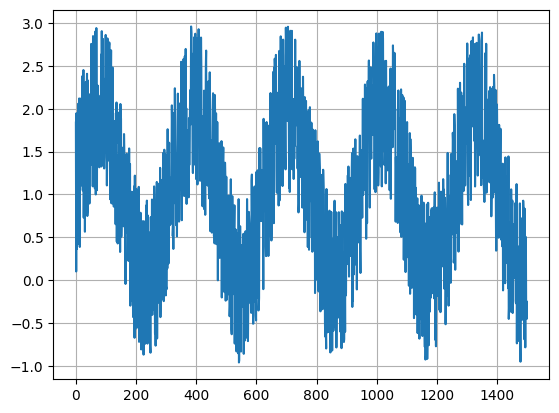

In [3]:
data = 1500
x = np.arange(data)
x = np.sin(0.02 * x) + np.random.rand(data) * 2

fig, ax = plt.subplots()
ax.plot(x)
ax.grid()

In [4]:
def convertToDataset(data, step):
    x, y = [], []
    for i in range(len(data) - step):
        x.append(data[i:i+step])
        y.append(data[i+step])
    return np.array(x, dtype='float32'), np.array(y, dtype='float32')

In [5]:
validation_split = int(0.8 * len(x))
x_train = x[:validation_split]
x_test = x[validation_split:]

x_train, y_train = convertToDataset(x_train, 10)
x_test, y_test = convertToDataset(x_test, 20)

In [6]:
def get_uncompiled_model(input_shape):
    inputs = keras.layers.Input(shape=input_shape)
    x = LSTM(64, return_sequences=False)(inputs)
    x = Dense(1)(x)
    return keras.models.Model(inputs=inputs, outputs=x)

model = get_uncompiled_model(input_shape=(None, 1))

model.compile(
    loss='mean_squared_error',
    optimizer='rmsprop'
)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 1)]         0         
                                                                 
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
history = model.fit(
    x_train, y_train,
    batch_size=16,
    epochs=100,
    validation_data=(x_test, y_test)
)

Epoch 1/100
75/75 [==============================] - 2s 8ms/step - loss: 0.4676 - val_loss: 0.5434
Epoch 2/100
75/75 [==============================] - 0s 5ms/step - loss: 0.3856 - val_loss: 0.3916
Epoch 3/100
75/75 [==============================] - 0s 5ms/step - loss: 0.3888 - val_loss: 0.4649
Epoch 4/100
75/75 [==============================] - 0s 5ms/step - loss: 0.3854 - val_loss: 0.4989
Epoch 5/100
75/75 [==============================] - 0s 5ms/step - loss: 0.3860 - val_loss: 0.3504
Epoch 6/100
75/75 [==============================] - 0s 5ms/step - loss: 0.3798 - val_loss: 0.3475
Epoch 7/100
75/75 [==============================] - 0s 5ms/step - loss: 0.3798 - val_loss: 0.3441
Epoch 8/100
75/75 [==============================] - 0s 5ms/step - loss: 0.3814 - val_loss: 0.3570
Epoch 9/100
75/75 [==============================] - 0s 5ms/step - loss: 0.3778 - val_loss: 0.3433
Epoch 10/100
75/75 [==============================] - 0s 5ms/step - loss: 0.3817 - val_loss: 0.3761
Epoch 11/

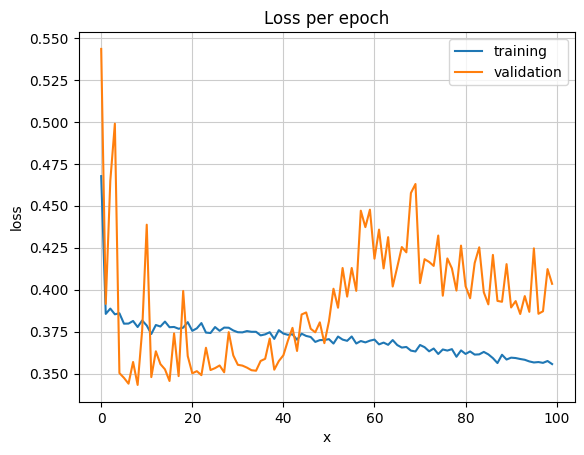

In [8]:
fig, ax = plt.subplots()
ax.plot(history.epoch, history.history['loss'], label='training')
ax.plot(history.epoch, history.history['val_loss'], label='validation')
ax.set_title('Loss per epoch')
ax.set_xlabel('x')
ax.set_ylabel('loss')
ax.grid(c='#ccc')
plt.legend()

9/9 [==============================] - 0s 3ms/step


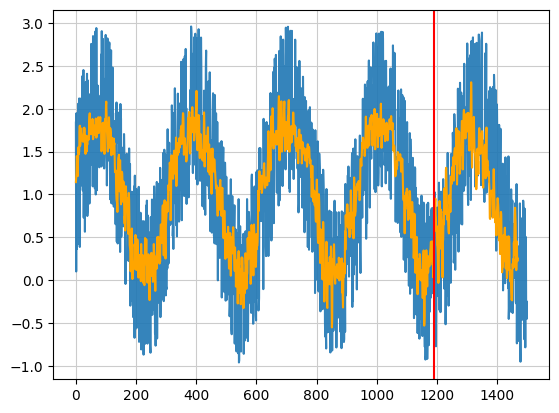

In [9]:
trainPredict = model.predict(x_train)
testPredict= model.predict(x_test)
predicted=np.concatenate((trainPredict,testPredict),axis=0)

plt.plot(x, alpha=0.9)
plt.plot(predicted, alpha=1, c='orange')
plt.axvline(len(x_train), c="r")
plt.grid(c='#ccc')
plt.show()